# Building Autoencoder in Keras

What are autoecnoders?
![title](img/autoencoder_schema.jpg)
"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

In [1]:
#the imports
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Are they good at data compression?
Usually, not really. In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: you can only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data. But future advances might change this, who knows.

# What are autoencoders good for?
Today two interesting practical applications of autoencoders are:
1. data denoising, 
2. non linear dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints,autoencoders can learn data projections that are more interesting than PCA or other basic techniques.
3. Reinforcement Learning
4. Seemi-Supervised Learning, we have lots of unlabeled data and some labeled data. 

# Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)


In [4]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
#autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [7]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.3607 - val_loss: 0.2705
Epoch 2/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.2626 - val_loss: 0.2513
Epoch 3/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.2417 - val_loss: 0.2295
Epoch 4/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.2212 - val_loss: 0.2108
Epoch 5/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.2058 - val_loss: 0.1983
Epoch 6/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1951 - val_loss: 0.1893
Epoch 7/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1869 - val_loss: 0.1818
Epoch 8/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1800 - val_loss: 0.1754
Epoch 9/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1741 - val_loss: 0.1699
Epoch

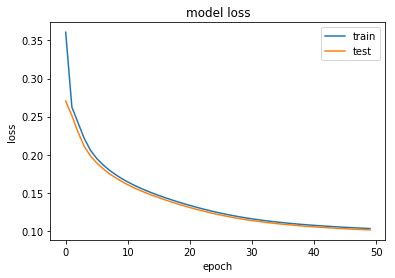

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

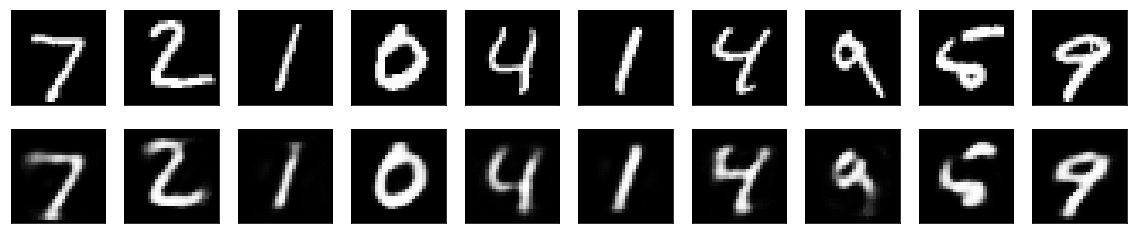

In [10]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Variational autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

Let’s define some notions:
1. $X$: data that we want to model a.k.a the animal
2. $z$: latent variable a.k.a our imagination
3. $P(X)$: probability distribution of the data, i.e. that animal kingdom
4. $P(z)$: probability distribution of latent variable, i.e. our brain, the source of our imagination
5. $P(X|z)$: distribution of generating data given latent variable, e.g. turning imagination into real animal


Our objective here is to model the data, hence we want to find $P(X)$ Using the law of probability, we could find it in relation with $z$ as follows:
<h1><center>$P(X) = \int P(X|z)P(z)dz$</center></h1>
that is, we marginalize out $z$ from the joint probability distribution $P(X,z)$.

The idea of VAE is to infer $P(z)$ using $P(z|X)$. This is make a lot of sense if we think about it: we want to make our latent variable likely under our data. Talking in term of our fable example, we want to limit our imagination only on animal kingdom domain, so we shouldn’t imagine about things like root, leaf, tyre, glass, GPU, refrigerator, doormat, … as it’s unlikely that those things have anything to do with things that come from the animal kingdom. Right?

But the problem is, we have to infer that distribution $P(z|X)$, as we don’t know it yet. In VAE, as it name suggests, we infer $P(z|X)$ using a method called Variational Inference (VI). VI is one of the popular choice of method in bayesian inference, the other one being MCMC method. The main idea of VI is to pose the inference by approach it as an optimization problem. How? By modeling the true distribution $P(z|X)$ using simpler distribution that is easy to evaluate, e.g. Gaussian, and minimize the difference between those two distribution using KL divergence metric, which tells us how difference it is $P$ and $Q$.

# Kullback–Leibler divergence
Alright, now let’s say we want to infer $P(z|X)$ using $Q(z|X)$. The KL divergence then formulated as follows:
<h1><center>$D_{KL}[Q[z|X)||P(z|X)] = \sum_z Q(z|X) \log \frac{Q(z|X)}{P(z|X)} = E_Q[\log Q(z|X) - \log P(z|X)]$</center></h1>
# What KL-Divergence do?
* allows use to compare 2 probability distributions
* if $Q $ is the same as  $P$, then KLD = 0
* if $Q$ is different from  $P$, KLD > 0


# The cost function
The cost function we want to minimise is the negative of the evidence lower bound: 'ELBO':
<h1><center>$ELBO = E[\log P(X|z)] - D_{KL} [Q(z|X) ||P(z)]$</center></h1>

The first term is $E[\log P(X|z)]$ is the cross entropy we know. 
The second term is the KL divergence between the prior $P(z)$ and our latent model. We can choose the prior distribution any distribution we want, but it is much simpler to use normal distribution: $P(z) = N(0,1)$. 

# KL distribution between two normal distribution
I am using book: The Matrix Cookbook from: http://coin.wne.uw.edu.pl/pbiernacki/matrix_cookbook.pdf
1. $Q(z|X) = N(\mu_1, \Sigma_1^2)$
2. $P(z) = N(\mu_2, \Sigma_2^2)$
3. $D_{KL}[Q(z|X)||P(z:X)] = \int P(z) [\log P(z) - \log Q(z|X)] dz$
4. $D_{KL}[N(\mu_1, \Sigma_1)||N(\mu_2,\Sigma_2)]= \frac{1}{2} [\log \frac{|\Sigma_2|}{|\Sigma_1|} - d  + tr{\Sigma_2^{-1}\Sigma_1} + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1)]$
4. $d$ is the dimension of the latent vector.

If we have $d=1$, and $P(x) = N(0,1)$ then the formula becomes very simple.
$KL [N(\mu, \Sigma^2) || N(0,1)  ] = \frac{1}{2}(\log(\Sigma) -1  + \Sigma + \mu^2)$ 

In [13]:
#tensor flow allows you to get the KL between two distribution...
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as dis
Normal = tf.contrib.distributions.Normal
t = dis.kl(Normal(3.0, 2.0), Normal(0.0, 1.0))
t2  =  dis.kl(Normal(3.0, 1.0), Normal(2.9,1.0))
t3 =  dis.kl(Normal(3.0, 1.0), Normal(3.0,1.0))

with tf.Session() as session:
    t_val = session.run(t)
    print ('KLD(N(3,2), N(0,1)) =', t_val, ", value = ", .5*(np.log(2)  - 1  + 2.0 + 3**2 ))
    t_val = session.run(t2)
    print('KLD(N(3,1), N(2.9,1)) =', t_val)
    t_val = session.run(t3)
    print('KLD(N(3,1), N(3,1)) =', t_val)

KLD(N(3,2), N(0,1)) = 5.30685 , value =  5.34657359028
KLD(N(3,1), N(2.9,1)) = 0.00499999
KLD(N(3,1), N(3,1)) = 0.0


# Implementing the variational auto encoder


In [14]:
#Imports
import numpy as np
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

#hyper parameters
batch_size = 200
latent_dim = 2
intermediate_dim = 625
epochs = 150
epsilon_std = 1.0


#data
original_dim = 784

In [15]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

#latent variables
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [16]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


In [17]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [18]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


/Users/unityspace/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [20]:
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)



Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 22s 361us/step - loss: 195.8928 - val_loss: 174.6839
Epoch 2/150
60000/60000 [==============================] - 19s 323us/step - loss: 171.5483 - val_loss: 169.1748
Epoch 3/150
60000/60000 [==============================] - 20s 325us/step - loss: 167.6890 - val_loss: 166.8844
Epoch 4/150
60000/60000 [==============================] - 23s 380us/step - loss: 165.3429 - val_loss: 164.3561
Epoch 5/150
60000/60000 [==============================] - 19s 324us/step - loss: 163.6507 - val_loss: 162.7508
Epoch 6/150
60000/60000 [==============================] - 20s 329us/step - loss: 162.3494 - val_loss: 162.3504
Epoch 7/150
60000/60000 [==============================] - 20s 325us/step - loss: 161.3160 - val_loss: 160.9336
Epoch 8/150
60000/60000 [==============================] - 20s 332us/step - loss: 160.3496 - val_loss: 161.0599
Epoch 9/150
60000/60000 [=============================

60000/60000 [==============================] - 24s 401us/step - loss: 147.0243 - val_loss: 151.4834
Epoch 74/150
60000/60000 [==============================] - 24s 395us/step - loss: 146.9393 - val_loss: 151.2653
Epoch 75/150
60000/60000 [==============================] - 22s 371us/step - loss: 146.8520 - val_loss: 151.6464
Epoch 76/150
60000/60000 [==============================] - 25s 416us/step - loss: 146.8205 - val_loss: 151.8209
Epoch 77/150
60000/60000 [==============================] - 29s 475us/step - loss: 146.7578 - val_loss: 152.0688
Epoch 78/150
60000/60000 [==============================] - 29s 480us/step - loss: 146.6979 - val_loss: 150.9640
Epoch 79/150
60000/60000 [==============================] - 27s 456us/step - loss: 146.6183 - val_loss: 151.4948
Epoch 80/150
60000/60000 [==============================] - 24s 396us/step - loss: 146.5660 - val_loss: 151.4096
Epoch 81/150
60000/60000 [==============================] - 21s 357us/step - loss: 146.4880 - val_loss: 151.7

60000/60000 [==============================] - 21s 350us/step - loss: 144.0750 - val_loss: 151.3313
Epoch 146/150
60000/60000 [==============================] - 22s 362us/step - loss: 144.0468 - val_loss: 151.9539
Epoch 147/150
60000/60000 [==============================] - 21s 356us/step - loss: 144.0795 - val_loss: 151.3494
Epoch 148/150
60000/60000 [==============================] - 21s 355us/step - loss: 144.0274 - val_loss: 151.9986
Epoch 149/150
60000/60000 [==============================] - 23s 384us/step - loss: 143.9737 - val_loss: 153.7341
Epoch 150/150
60000/60000 [==============================] - 22s 366us/step - loss: 143.9734 - val_loss: 151.8092


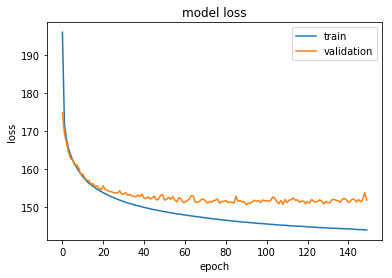

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

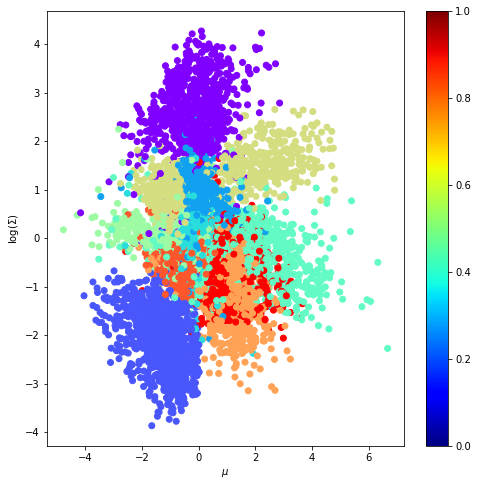

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 8))
colors = cm.rainbow(np.linspace(0, 1, len(set(y_test))))
colors = colors[np.asarray(y_test)]

plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=colors)


plt.xlabel("$\mu$")
plt.ylabel("$\log(\Sigma)$")
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(colors)
plt.colorbar(m)

In [23]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)



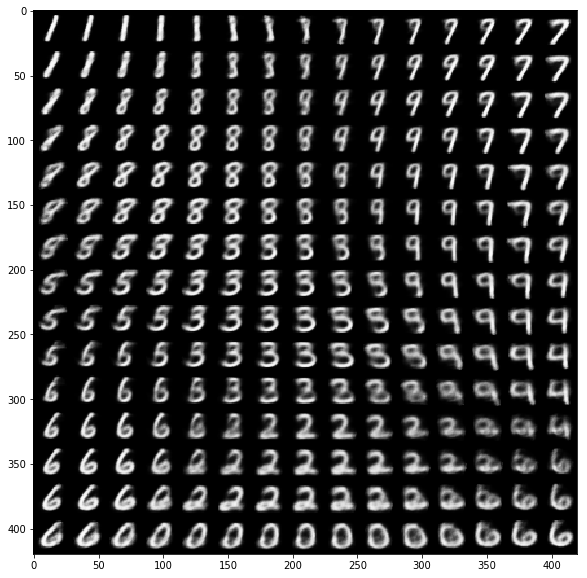

In [24]:
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

# Application to image denoising
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [25]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

add gaussian noise


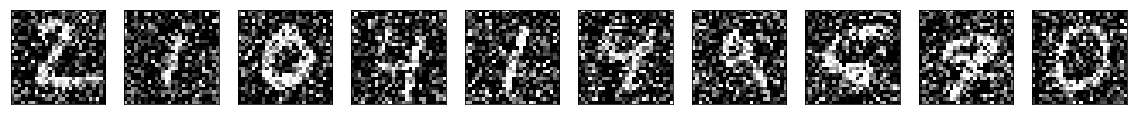

In [26]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [27]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's train it for 50 epochs:

In [29]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=1,#50
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 216s 4ms/step - loss: 0.1068 - val_loss: 0.1035


Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.



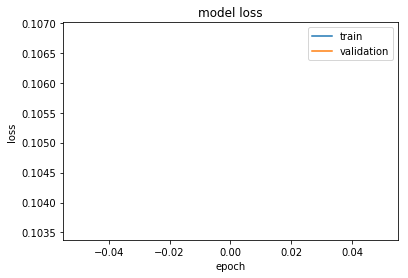

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

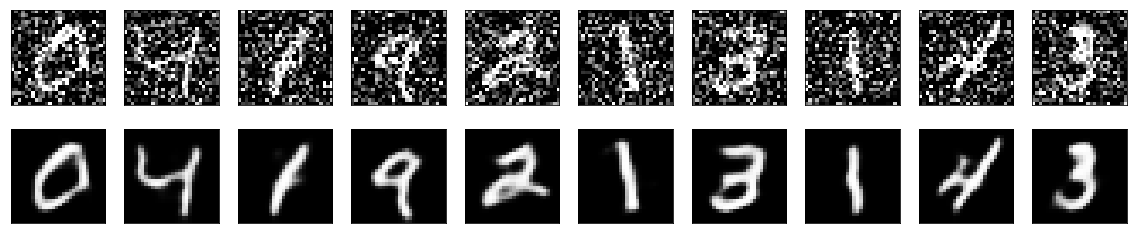

In [34]:
decoded_imgs = autoencoder.predict(x_train_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()